# PROJETO FINAL 
## Uma Abordagem Automática para Detecção de Grupos Públicos do WhatsApp

- Disciplina: Natural Language Processing
- Daniel Pimentel Kansaon


## Objetivos

## Organização do Trabalho

# BIBLIOTECAS

In [2]:
import json
import gzip
import pandas as pd
import re
import string
import os
from tqdm import tqdm
from collections import Counter

from nltk.corpus import stopwords
from nltk import word_tokenize

import plotly.express as px

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import keras.utils as util

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.utils as util
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import SimpleRNN
from keras.layers import LSTM, Bidirectional
from keras.layers import Dropout
from keras import backend as K
from keras import layers
from keras.models import Model
from keras.layers import Flatten

from keras.layers import Conv1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import MaxPooling1D

from keras.layers import Input
from sklearn.utils import class_weight
from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

import numpy as np
import matplotlib.pyplot as plt

from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plot
#import seaborn as sns; sns.set_theme()
import plotly.graph_objects as go

from wordcloud import WordCloud 

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

# CONSTANTES

In [87]:
FILE_PATH_ZAP = './scripts/final_data/db_grupos_de_zap.json.gz'
FILE_PATH_WHATS = './scripts/final_data/db_grupos_whats.json.gz'
FILE_PATH_CATEG = './scripts/final_data/categories.csv'
EMBEDDING_SIZE = 100
EMBEDDING_PATH = '/home/daniel/Downloads'
K_FOLD = 5
N_CLASSES = 21

STOP_WORDS = set(stopwords.words('portuguese'))
STOP_WORDS.update(['bem vindo', 'bem', 'vindo', 'pra', 'vc', 'etc', 'aqui', 'grupo'])

# MÉTODOS UTILIZADOS

In [4]:
def read_data(path):
    with gzip.open(path, 'r') as fin:      
        json_bytes = fin.read()  

        json_str = json_bytes.decode('utf-8')            
        data = json.loads(json_str)
    
    return data

## Leitura dos Dados

In [5]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F" 
                               u"\U0001F300-\U0001F5FF"  
                               u"\U0001F680-\U0001F6FF"  
                               u"\U0001F1E0-\U0001F1FF"  
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [6]:
def process_text(text):
    text = remove_emoji(text) #REMOVE EMOJIS
    text = ' '.join([word for word in text.split() if word not in STOP_WORDS]) #REMOVE STOPWORDS
    text = text.translate(str.maketrans('', '', string.punctuation)) #REMOVE PONTUAÇÃO
    text = ' '.join([word for word in text.split() if not word.isdigit()]) #REMOVE DIGITOS
    
    return text.lower()

In [7]:
def get_df_data(data):
    desc = [data[i]['title'] + ' ' + data[i]['description'] for i in range(0, len(data))]
    cat = [d['category'] for d in data]
    return pd.DataFrame({'description': desc, 'category': cat})

#https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a
#https://colab.research.google.com/github/dipanjanS/nlp_workshop_odsc19/blob/master/Module05%20-%20NLP%20Applications/Project07B%20-%20Text%20Classification%20Deep%20Learning%20CNN%20Models.ipynb#scrollTo=AXhAERVeXhmZ

## Função para Matriz de Confusão

In [8]:
def plot_confusion_matrix(model, x_train, y_train):    
    y_pred = np.argmax(x_train, axis=1)

    # Labels (desfaz o one-hot encode)
    y_true = np.argmax(y_train, axis=1)

    cm = confusion_matrix(y_true, y_pred, normalize='true')
    #print(classification_report(y_true, y_pred))
    
    classes = list(range(1, N_CLASSES))
    fig, ax = plt.subplots(figsize=(14, 14))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=ALL_CATEGORIES, yticklabels=ALL_CATEGORIES,
    title="Matriz de Confusão",
    ylabel="Real",
    xlabel="Predito")

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
    rotation_mode="anchor")

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j,i,str(round(cm[i, j], 2)).strip(), ha="center", va="center",
                   color="white" if cm[i, j] > cm.max()/2. else "black")
    fig.tight_layout()
    plt.show()

## Função para plotar uma CDF

In [9]:
def plot_cdf_n_curves(list_curve, label_curve, x_label, chart_path, isLog=True):
    n = len(list_curve)
    ecdf_list = list()
    
    for k in range(n):
        list_curve[k].sort()
        cdf = ECDF(list_curve[k])
        ecdf_list.append(cdf)
    
    fig, ax = plt.subplots()
    plt.grid()
    for k in range(n):
        plt.plot(ecdf_list[k].x, ecdf_list[k].y, label=label_curve[k], linewidth=2)
   
    plt.legend(loc='lower right')
    if isLog:
        chart_path = chart_path+'_log'
        ax.set_xscale('log')
        
    ax.set_xlabel(x_label)
    ax.set_ylabel('CDF')
    plt.tight_layout()
    plot.show()

In [89]:
def plot_training_performance(acc, val_acc, title):
    plt.figure(figsize=(6,4))
    plt.plot(acc)
    plt.plot(val_acc)

    plt.title(title)
    plt.ylabel('Acurácia')
    plt.xlabel('Épocas')

    plt.legend(['Treino', 'Teste'], loc="lower right")
    plt.show()

In [90]:

def plot_word_cloud(texts):
    
    long_string = ','.join(texts)
    # Create a WordCloud object

    wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue', width=1000, height=500)
    # Generate a word cloud

    wordcloud.generate(long_string)

    # Visualize the word cloud
    #wordcloud.to_file('words.png')
    return wordcloud.to_image()

# BASE DE DADOS

In [118]:
df_base1 = get_df_data(read_data(FILE_PATH_ZAP))
df_base2 = get_df_data(read_data(FILE_PATH_WHATS))

## Pré-Processamento

In [119]:
#Remove stopwords, números, pontuações e emojis.
df_base1['description'] = df_base1['description'].apply(process_text)
df_base2['description'] = df_base2['description'].apply(process_text)

In [120]:
#Remove grupos com descrição nula
df_base1.drop(index=df_base1[df_base1['description'] == ''].index, inplace=True)
df_base2.drop(index=df_base2[df_base2['description'] == ''].index, inplace=True)

In [121]:
#Remove grupos duplicados
df_base1 = df_base1.drop_duplicates()
df_base2 = df_base2.drop_duplicates()

In [125]:
df_base1.drop_duplicates(subset='description')

,description,category
0,stranger things amizades conversas geral não s...,filmes e séries
1,canais filmes séries conheça melhor lista cana...,"tv, desenhos e animes"
2,cristo salvador muitas pessoas hoje acham text...,religião
3,flamengo crf oficial lll domingo mengo mengo d...,esportes e academia
4,flamengo crf oficial ll respeito todos fundame...,esportes e academia
...,...,...
17852,crush 24h acha amor apenas fazer amizades msm,amor e romance
17853,pop music obrigatório sempre mandar música col...,música
17854,äbïgūínhøs ø criei intuito conversar sobre ani...,"tv, desenhos e animes"
17855,1kilo fans 1kilo,música


## Volume das Bases de Dados

In [122]:
print("Dataset 1- Total: ", len(df_base1))
print("Dataset 2- Total: ", len(df_base2))
print("Total Categorias: ", len(Counter(df_base1['category'])))

Dataset 1- Total:  17762
Dataset 2- Total:  109082
Total Categorias:  21


## Distribuição das Categorias

In [96]:
qtd_cat_base1 = Counter(df_base1['category'])
qtd_cat_base2 = Counter(df_base2['category'])

In [153]:
df1 = pd.DataFrame({"Dados": ['Base 1' for i in range(N_CLASSES)], "Categoria": list(qtd_cat_base1.keys()), "Quantidade": list(qtd_cat_base1.values())})
df2 = pd.DataFrame({"Dados": ['Base 2' for i in range(N_CLASSES)], "Categoria": list(qtd_cat_base2.keys()), "Quantidade": list(qtd_cat_base2.values())})

fig = px.bar(pd.concat([df1, df2]), color='Dados', y='Categoria', x='Quantidade')
fig.show()

## Detalhamento de Cada Classe

In [129]:
categ_desc = pd.read_csv(FILE_PATH_CATEG, sep=';')
fig = go.Figure(data=[go.Table(header=dict(values=['Categoria', 'Descrição']),
                 cells=dict(values=[list(categ_desc['categoria']), list(categ_desc['descricao'])]))
                     ])
fig.show()

## Distribuição das Categorias
- 80% das categorias do dataset 1 tem menos de 1000 grupos
- 70% das categorias do dataset 2 mais de 1000 grupos

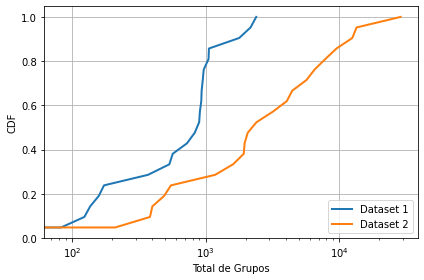

In [130]:
cdf_db1 = list(qtd_cat_base1.values())
cdf_db2 = list(qtd_cat_base2.values())

plot_cdf_n_curves([cdf_db1, cdf_db2], ['Dataset 1', 'Dataset 2' ], 'Total de Grupos', 'Categoria', isLog=True)

## Núvem de Termos

## Dataset 1

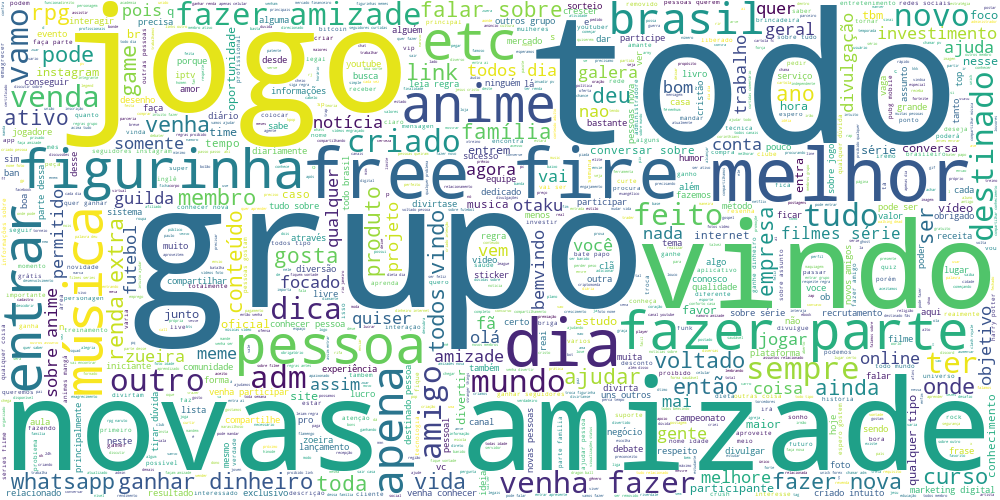

In [73]:
plot_word_cloud(df_base1['description'])

## Dataset 2

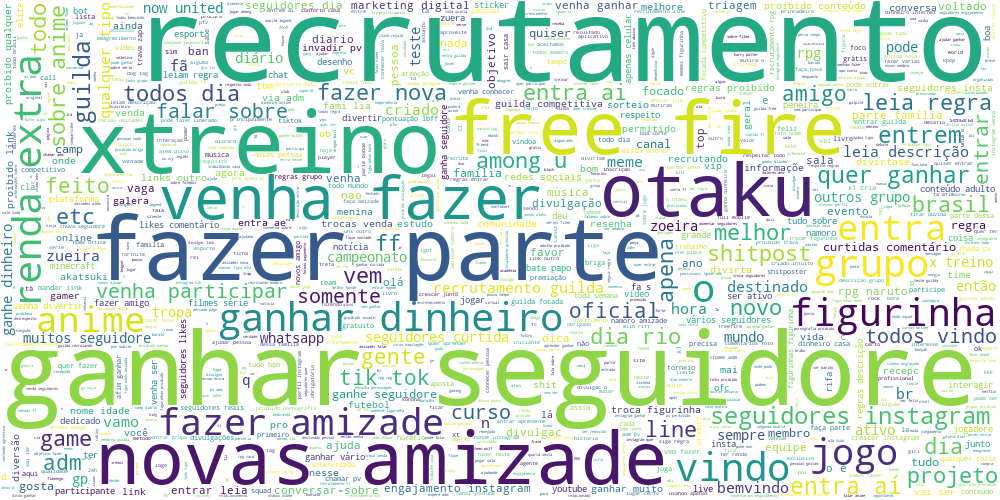

In [74]:
plot_word_cloud(df_base2['description'])

# PREPARAÇÃO DOS DADOS

In [131]:
#df_base1.drop(index=df_base1[df_base1['category'] == 'amizade'].index, inplace=True)
#df_base2.drop(index=df_base2[df_base2['category'] == 'amizade'].index, inplace=True)

#df_base1.loc[(df_base1.category == 'vagas de empregos'),'category']='empregos e profissões'
#df_base2.loc[(df_base2.category == 'vagas de empregos'),'category']='empregos e profissões'

#df_base1 = df_base1[df_base1['category'].isin(catego)]
#df_base2 = df_base2[df_base2['category'].isin(catego)]


## Tokenizar as sentences

In [86]:
all_descriptions = list(df_base1['description'])
all_descriptions.extend(list(df_base2['description']))

word_tokenizer = Tokenizer(split = ' ')
word_tokenizer.fit_on_texts(all_descriptions)

MAX_WORDS_SENTENCES = 81

SENTENCES_BASE1 = word_tokenizer.texts_to_sequences(df_base1['description']) 
SENTENCES_BASE1 = pad_sequences(SENTENCES_BASE1, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

SENTENCES_BASE2 = word_tokenizer.texts_to_sequences(df_base2['description']) 
SENTENCES_BASE2 = pad_sequences(SENTENCES_BASE2, maxlen = MAX_WORDS_SENTENCES, padding="pre", truncating="post")

In [79]:
maior = 0
for c in all_descriptions:
    if maior < len(c.split(' ')):
        maior = len(c.split(' '))
        
print("Maior Sentença: ", maior)

Maior Sentença:  81


In [81]:
VOCABULARY_SIZE = len(word_tokenizer.word_index) + 1
print('Tamanho do Vocabulário: ', VOCABULARY_SIZE)

Tamanho do Vocabulário:  118880


## Tokenizar a Saída (classes)

In [82]:
ALL_CATEGORIES = list(set(df_base1['category']))
CATEGORY_BASE1 = [ALL_CATEGORIES.index(cat) for cat in df_base1['category']] 
CATEGORY_BASE2 = [ALL_CATEGORIES.index(cat) for cat in df_base2['category']] 

print('ALL: ', ALL_CATEGORIES)
print('Total: ' ,len(ALL_CATEGORIES))

ALL:  ['figurinhas e stickers', 'notícias', 'filmes e séries', 'fãs', 'educação e estudo', 'games e jogos', 'política', 'redes sociais', 'festas, baladas e eventos', 'esportes e academia', 'saúde, emagrecimento e beleza', 'religião', 'memes engraçados e zoeira', 'música', 'empregos e profissões', 'tv, desenhos e animes', 'ganhar dinheiro', 'carros e motos', 'frases e mensagens', 'amor e romance', 'receitas']
Total:  21


In [83]:
class_weights_db1 = dict(zip(np.unique(CATEGORY_BASE1), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(CATEGORY_BASE1), y=CATEGORY_BASE1)))
class_weights_db2 = dict(zip(np.unique(CATEGORY_BASE2), class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(CATEGORY_BASE2), y=CATEGORY_BASE2)))

In [84]:
CATEGORY_BASE1 = util.np_utils.to_categorical(CATEGORY_BASE1, N_CLASSES)
CATEGORY_BASE2 = util.np_utils.to_categorical(CATEGORY_BASE2, N_CLASSES)

print('\nSHAPE: ', CATEGORY_BASE1.shape)
print('SHAPE: ', CATEGORY_BASE2.shape)


SHAPE:  (17762, 21)
SHAPE:  (109082, 21)


# Carregar Embeddings


In [85]:
def load_word_embedding(word_index, dimension_embedding):
    dic_embedding = {}
    
    file_embedding = open(os.path.join(EMBEDDING_PATH, "skip_s{}.txt".format(dimension_embedding)), encoding='utf-8')
    
    #Carregando os WordEmbeddings para um dicionario
    for line in tqdm(file_embedding):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefficient = np.asarray(values[1:], dtype='float32')
        dic_embedding[word] = coefficient
            
    file_embedding.close()
    
    #Cria a matrix com em que serão carregados os embeddings
    matrix_embedding = np.zeros((VOCABULARY_SIZE, dimension_embedding))
    
    for word, i in word_index.items():
        if i >= VOCABULARY_SIZE:
            continue
        
        vector_embedding = dic_embedding.get(word)
        
        if vector_embedding is not None:
            matrix_embedding[i] = vector_embedding

    return matrix_embedding

In [98]:
MATRIX_EMBEDDING = load_word_embedding(word_tokenizer.word_index, EMBEDDING_SIZE)

929607it [00:22, 41006.42it/s]


# CLASSIFICAÇÃO

In [99]:
#https://proeducacional.com/ead/curso-cga-modulo-i/capitulos/capitulo-4/aulas/intervalo-de-confianca-distribuicao-t-de-student/

def calc_conf_interval(v_validation):
    tbl_t_95 = 2.776 #Valor na tabela T-Student (4 graus de liberdade)
    mean = np.mean(v_validation, dtype=np.float64)
    std = np.std(v_validation)
        
    return [mean, (mean - (tbl_t_95 * std)), (mean + (tbl_t_95 * std)), tbl_t_95 * std]

In [100]:
def execute_logistic_regression(texts_words, y_class, weight):    
    accuracy_train = []
    accuracy_test = []
    skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)

    #Vectoriza os textos, transformando em vetores de números, que representam as frequências
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None)   
        
    #Executa a validação cruzada com 5 Folds
    for train_index, test_index in skf.split(texts_words, y_class):       
        #Cria o modelo
        model_logc = LogisticRegression(solver='newton-cg', class_weight=weight)
        
        #Cria o pipeline para executar o método
        pipe_logc= Pipeline([('vectorizer', vectorizer), ('model_logc', model_logc)])
        
        #Treina e testa salvando os resultados
        pipe_logc.fit(np.array(texts_words)[train_index], np.array(y_class)[train_index])
        accuracy_train.append(pipe_logc.score(np.array(texts_words)[train_index], np.array(y_class)[train_index]))
        accuracy_test.append(pipe_logc.score(np.array(texts_words)[test_index], np.array(y_class)[test_index]))
        break
        
    return accuracy_train, accuracy_test

## Modelo LSTM

In [101]:
def load_lstm():
    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim     = VOCABULARY_SIZE,        
                             output_dim    = EMBEDDING_SIZE,          
                             input_length  = MAX_WORDS_SENTENCES,     
                             weights       = [MATRIX_EMBEDDING],    
                             trainable     = True                   
    ))

    lstm_model.add(Bidirectional(LSTM(64, return_sequences=True, recurrent_dropout=0.1)))
    lstm_model.add(Flatten())

    lstm_model.add(Dense(N_CLASSES, activation='softmax'))
    
    lstm_model.compile(loss =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
    
    return lstm_model

## Modelo CNN

In [102]:
def load_cnn1d():
    cnn_model = Sequential()

    cnn_model.add(Embedding(input_dim     = VOCABULARY_SIZE,         
                             output_dim    = EMBEDDING_SIZE,         
                             input_length  = MAX_WORDS_SENTENCES,    
                             weights       = [MATRIX_EMBEDDING],     
                             trainable     = True                    
    ))

    cnn_model.add(Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=4))

    cnn_model.add(Dense(20, activation='relu'))
    cnn_model.add(Dropout(0.25))
    cnn_model.add(Flatten())

    cnn_model.add(Dense(N_CLASSES, activation='sigmoid'))
    
    cnn_model.compile(loss =  'categorical_crossentropy',
                   optimizer =  'adam',
                   metrics   =  ['acc'])
    
    return cnn_model

# DATASET 1

## Dataset 1: Treinamento Logistic Regression

In [48]:
labels = np.argmax(CATEGORY_BASE1, axis=1)
result_train, result_test = execute_logistic_regression(list(df_base1['description']), labels, class_weights_db1)

if (len(result_train) > 1):
    print("RESULTADOS Logistic Regression\n")
    print("Treino: {} +- {:.2}".format(calc_conf_interval(result_train)[0], calc_conf_interval(result_train)[3]))
    print("Teste: {} +- {:.2}".format(calc_conf_interval(result_test)[0], calc_conf_interval(result_test)[3]))
else:
    print(np.mean(result_train))
    print(np.mean(result_test))

0.9914138926032796
0.7348719392063046


## Dataset 1: Treinamento LSTM

In [103]:
lstm_model_db1 = load_lstm()
lstm_model_db1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 81, 100)           11888000  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 81, 128)           84480     
_________________________________________________________________
flatten_1 (Flatten)          (None, 10368)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 21)                217749    
Total params: 12,190,229
Trainable params: 12,190,229
Non-trainable params: 0
_________________________________________________________________


In [104]:
#Separa os dados para a validação cruzada
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

In [105]:
i = 1

lstm_db1_accuracy = []
lstm_db1_macro_f1 = []
lstm_db1_wg_f1 = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE1, np.argmax(CATEGORY_BASE1, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))       
    lstm_model_db1 = load_lstm()
    
    db1_lstm_training = lstm_model_db1.fit(
        SENTENCES_BASE1[train_index], 
        CATEGORY_BASE1[train_index], 
        validation_data=(SENTENCES_BASE1[test_index], CATEGORY_BASE1[test_index]),
        epochs=8,
        batch_size=1024, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db1) 
    
    true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
    pred = np.argmax(lstm_model_db1.predict(SENTENCES_BASE1[test_index]), axis=1)
    
    lstm_db1_accuracy.append(metrics.accuracy_score(true, pred))
    lstm_db1_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    lstm_db1_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break

print("\nResultados:")        
print("Acurácia: ", sum(lstm_db1_accuracy)/i)
print("Macro-F1: ", sum(lstm_db1_macro_f1)/i)
print("Weighted-F1: ", sum(lstm_db1_wg_f1)/i)

1/5 - Folds

Train on 14209 samples, validate on 3553 samples
Epoch 1/8
14209/14209 [==============================] - 12s 817us/step - loss: 2.7062 - acc: 0.3515 - val_loss: 2.0844 - val_acc: 0.4545
Epoch 2/8
14209/14209 [==============================] - 12s 815us/step - loss: 1.8224 - acc: 0.4727 - val_loss: 1.6421 - val_acc: 0.5041
Epoch 3/8
14209/14209 [==============================] - 10s 711us/step - loss: 1.3489 - acc: 0.5871 - val_loss: 1.4064 - val_acc: 0.5961
Epoch 4/8
14209/14209 [==============================] - 11s 773us/step - loss: 1.0777 - acc: 0.6597 - val_loss: 1.3057 - val_acc: 0.6195
Epoch 5/8
14209/14209 [==============================] - 11s 752us/step - loss: 0.8824 - acc: 0.7107 - val_loss: 1.2048 - val_acc: 0.6673
Epoch 6/8
14209/14209 [==============================] - 10s 737us/step - loss: 0.7152 - acc: 0.7645 - val_loss: 1.1741 - val_acc: 0.6842
Epoch 7/8
14209/14209 [==============================] - 10s 731us/step - loss: 0.5765 - acc: 0.8023 - val_los

## Dataset 1: Resultado LSTM

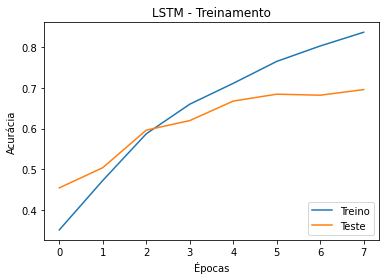

In [106]:
plot_training_performance(db1_lstm_training.history['acc'], db1_lstm_training.history['val_acc'], "LSTM - Treinamento")

## Dataset 1: Treinamento CNN

In [88]:
cnn_model_db1 = load_cnn1d()
cnn_model_db1.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 85, 100)           11888000  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 85, 128)           64128     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 21, 128)           0         
_________________________________________________________________
dense_7 (Dense)              (None, 21, 20)            2580      
_________________________________________________________________
dropout_3 (Dropout)          (None, 21, 20)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 420)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 21)               

In [138]:
i = 1

cnn_db1_accuracy = []
cnn_db1_macro_f1 = []
cnn_db1_wg_f1 = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE1, np.argmax(CATEGORY_BASE1, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))   
    cnn_model_db1 = load_cnn1d()
    
    db1_cnn_training = cnn_model_db1.fit(
        SENTENCES_BASE1[train_index], 
        CATEGORY_BASE1[train_index], 
        validation_data=(SENTENCES_BASE1[test_index], CATEGORY_BASE1[test_index]),
        epochs=5,
        batch_size=1024, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db1) 
    
    true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
    pred = np.argmax(cnn_model_db1.predict(SENTENCES_BASE1[test_index]), axis=1)
    
    cnn_db1_accuracy.append(metrics.accuracy_score(true, pred))
    cnn_db1_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    cnn_db1_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break

print("\nResultados:")
print("Acurácia: ", sum(cnn_db1_accuracy)/i)
print("Macro-F1: ", sum(cnn_db1_macro_f1)/i)
print("Weighted-F1: ", sum(cnn_db1_wg_f1)/i)

1/5 - Folds

Train on 14209 samples, validate on 3553 samples
Epoch 1/5
14209/14209 [==============================] - 5s 321us/step - loss: 3.0418 - acc: 0.0633 - val_loss: 3.0209 - val_acc: 0.1278
Epoch 2/5
14209/14209 [==============================] - 4s 279us/step - loss: 2.9946 - acc: 0.1325 - val_loss: 2.9736 - val_acc: 0.1610
Epoch 3/5
14209/14209 [==============================] - 4s 282us/step - loss: 2.9160 - acc: 0.1730 - val_loss: 2.8682 - val_acc: 0.2055
Epoch 4/5
14209/14209 [==============================] - 5s 329us/step - loss: 2.7164 - acc: 0.2156 - val_loss: 2.5671 - val_acc: 0.2775
Epoch 5/5
14209/14209 [==============================] - 5s 336us/step - loss: 2.4039 - acc: 0.2830 - val_loss: 2.2968 - val_acc: 0.3394

Resultados:
Acurácia:  0.3394314663664509
Macro-F1:  0.2697209641091036
Weighted-F1:  0.36015392595456786


## Dataset 1: Resultado CNN

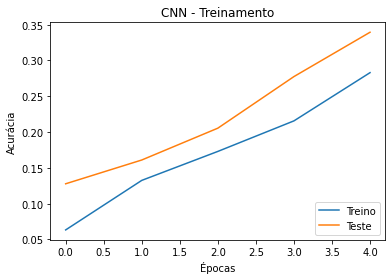

In [139]:
plot_training_performance(db1_cnn_training.history['acc'], db1_cnn_training.history['val_acc'], "CNN - Treinamento")

## Dataset 1: Matriz de Confusão do Melhor Modelo

In [107]:
results = lstm_model_db1.predict(SENTENCES_BASE1[test_index])

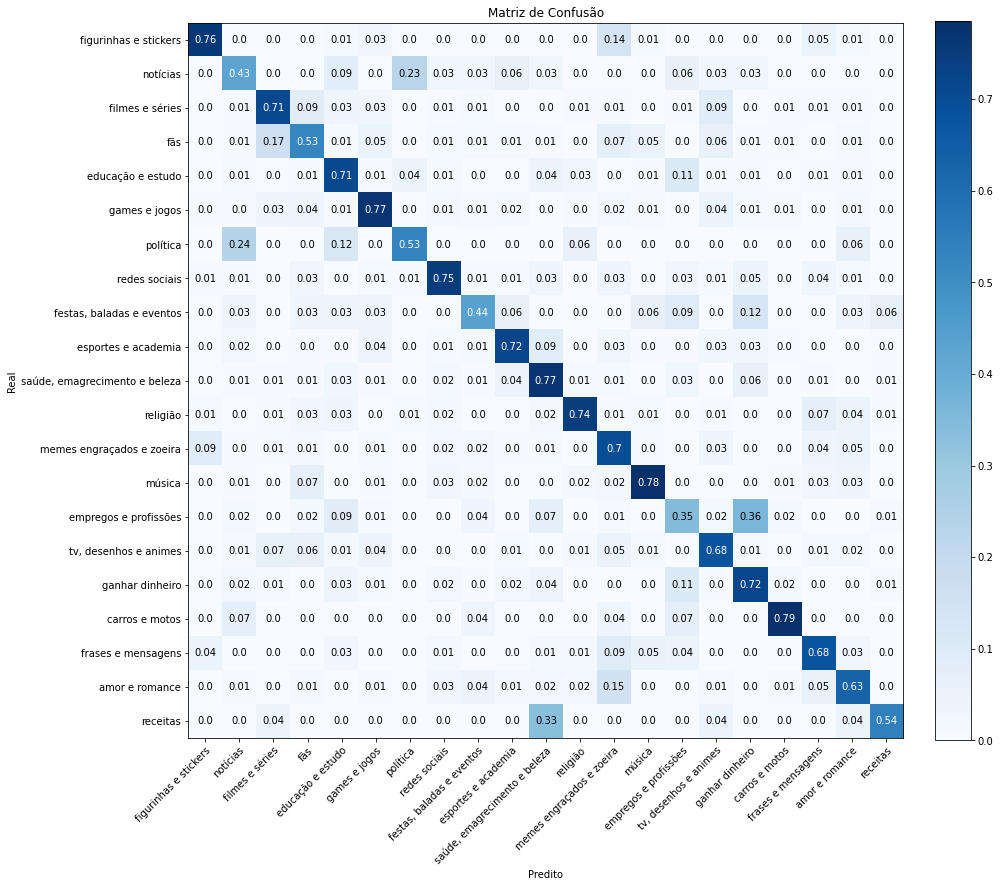

In [108]:
plot_confusion_matrix(lstm_model_db1, results, CATEGORY_BASE1[test_index])

## Dataset 1: Precisão das Classes

In [99]:
y_true = np.argmax(CATEGORY_BASE1[test_index], axis=1)
y_pred = np.argmax(results, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.35      0.31      0.33       210
           1       0.14      0.34      0.20        74
           2       0.45      0.28      0.35       146
           3       0.27      0.53      0.36       186
           4       0.08      0.76      0.15        17
           5       0.09      0.28      0.14        32
           6       0.54      0.61      0.57       181
           7       0.64      0.34      0.45       166
           8       0.57      0.11      0.19        35
           9       0.69      0.58      0.63       194
          10       0.49      0.81      0.61       108
          11       0.80      0.67      0.73       212
          12       0.24      0.20      0.22       113
          13       0.70      0.39      0.50       479
          14       0.54      0.59      0.56       190
          15       0.18      0.21      0.19        24
          16       0.69      0.68      0.68       434
          17       0.47    

## Dataset 1: Principais Pontos

Adicionar pontos

# DATASET 2

Repetir os mesmos processos da etapa anterior

In [63]:
SENTENCES_BASE2 = SENTENCES_BASE2[10000:]
CATEGORY_BASE2 = CATEGORY_BASE2[10000:]

## Dataset 2: Treinamento Logistic Regression

In [ ]:
labels = np.argmax(CATEGORY_BASE2, axis=1)
result_train, result_test = execute_logistic_regression(list(df_base2['description']), labels, class_weights_db2)

if (len(result_train) > 1):
    print("RESULTADOS Logistic Regression\n")
    print("Treino: {} +- {:.2}".format(calc_conf_interval(result_train)[0], calc_conf_interval(result_train)[3]))
    print("Teste: {} +- {:.2}".format(calc_conf_interval(result_test)[0], calc_conf_interval(result_test)[3]))
else:
    print(np.mean(result_train))
    print(np.mean(result_test))

## Dataset 2: Treinamento LSTM

In [81]:
#Separa os dados para a validação cruzada
skf = StratifiedKFold(n_splits=K_FOLD, shuffle=True)   

In [82]:
i = 1

lstm_db2_accuracy = []
lstm_db2_macro_f1 = []
lstm_db2_wg_f1 = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE2, np.argmax(CATEGORY_BASE2, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))       
    lstm_model_db2 = load_lstm()
    
    db2_lstm_training = lstm_model_db2.fit(
        SENTENCES_BASE2[train_index], 
        CATEGORY_BASE2[train_index], 
        validation_data=(SENTENCES_BASE2[test_index], CATEGORY_BASE2[test_index]),
        epochs=1,
        batch_size=2400, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db2) 
    
    true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
    pred = np.argmax(lstm_model_db2.predict(SENTENCES_BASE2[test_index]), axis=1)
    
    lstm_db2_accuracy.append(metrics.accuracy_score(true, pred))
    lstm_db2_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    lstm_db2_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break

print("\nResultados:")        
print("Acurácia: ", sum(lstm_db2_accuracy)/i)
print("Macro-F1: ", sum(lstm_db2_macro_f1)/i)
print("Weighted-F1: ", sum(lstm_db2_wg_f1)/i)

1/5 - Folds

Train on 79453 samples, validate on 19864 samples
Epoch 1/1
79453/79453 [==============================] - 58s 727us/step - loss: 2.4179 - acc: 0.3609 - val_loss: 1.9059 - val_acc: 0.4625

Resultados:
Acurácia:  0.4625453080950463
Macro-F1:  0.3787299833815346
Weighted-F1:  0.5031450740128136


## Dataset 2: Resultado LSTM

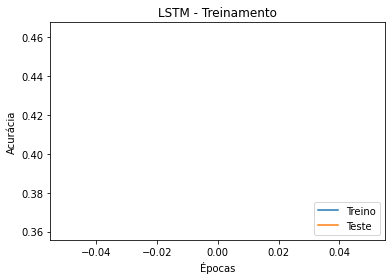

In [83]:
plot_training_performance(db2_lstm_training.history['acc'], db2_lstm_training.history['val_acc'], "LSTM - Treinamento")

## Dataset 2: Treinamento CNN

In [109]:
i = 1

cnn_db2_accuracy = []
cnn_db2_macro_f1 = []
cnn_db2_wg_f1 = []

#Executa o modelo
for train_index, test_index in skf.split(SENTENCES_BASE2, np.argmax(CATEGORY_BASE2, axis=1)):       
    print("{}/{} - Folds\n".format(1, K_FOLD))   
    cnn_model_db2 = load_cnn1d()
    
    db2_cnn_training = cnn_model_db2.fit(
        SENTENCES_BASE2[train_index], 
        CATEGORY_BASE2[train_index], 
        validation_data=(SENTENCES_BASE2[test_index], CATEGORY_BASE2[test_index]),
        epochs=6,
        batch_size=2548, 
        shuffle=True,
        verbose=1,
        class_weight=class_weights_db2) 
    
    true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
    pred = np.argmax(cnn_model_db2.predict(SENTENCES_BASE2[test_index]), axis=1)
    
    cnn_db2_accuracy.append(metrics.accuracy_score(true, pred))
    cnn_db2_macro_f1.append(metrics.f1_score(true, pred, average='macro'))
    cnn_db2_wg_f1.append(metrics.f1_score(true, pred, average='weighted'))
    
    if i == 1:
        break

print("\nResultados:")
print("Acurácia: ", sum(cnn_db2_accuracy)/i)
print("Macro-F1: ", sum(cnn_db2_macro_f1)/i)
print("Weighted-F1: ", sum(cnn_db2_wg_f1)/i)

1/5 - Folds

Train on 87265 samples, validate on 21817 samples
Epoch 1/6
87265/87265 [==============================] - 19s 217us/step - loss: 2.9843 - acc: 0.0719 - val_loss: 2.8863 - val_acc: 0.1712
Epoch 2/6
87265/87265 [==============================] - 19s 217us/step - loss: 2.5196 - acc: 0.2282 - val_loss: 2.0617 - val_acc: 0.4615
Epoch 3/6
87265/87265 [==============================] - 21s 235us/step - loss: 1.9343 - acc: 0.4032 - val_loss: 1.6485 - val_acc: 0.5703
Epoch 4/6
87265/87265 [==============================] - 21s 237us/step - loss: 1.5499 - acc: 0.5150 - val_loss: 1.5000 - val_acc: 0.5890
Epoch 5/6
87265/87265 [==============================] - 21s 235us/step - loss: 1.2892 - acc: 0.5886 - val_loss: 1.3007 - val_acc: 0.6547
Epoch 6/6
87265/87265 [==============================] - 20s 229us/step - loss: 1.1010 - acc: 0.6378 - val_loss: 1.2234 - val_acc: 0.6769

Resultados:
Acurácia:  0.6768574964477243
Macro-F1:  0.5565560512564997
Weighted-F1:  0.6930650937240238


## Dataset 2: Resultado CNN

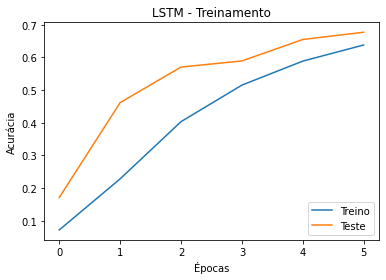

In [112]:
plot_training_performance(db2_cnn_training.history['acc'], db2_cnn_training.history['val_acc'], "LSTM - Treinamento")

## Dataset 2: Matriz de Confusão do Melhor Modelo

In [114]:
results = cnn_model_db2.predict(SENTENCES_BASE2[test_index])

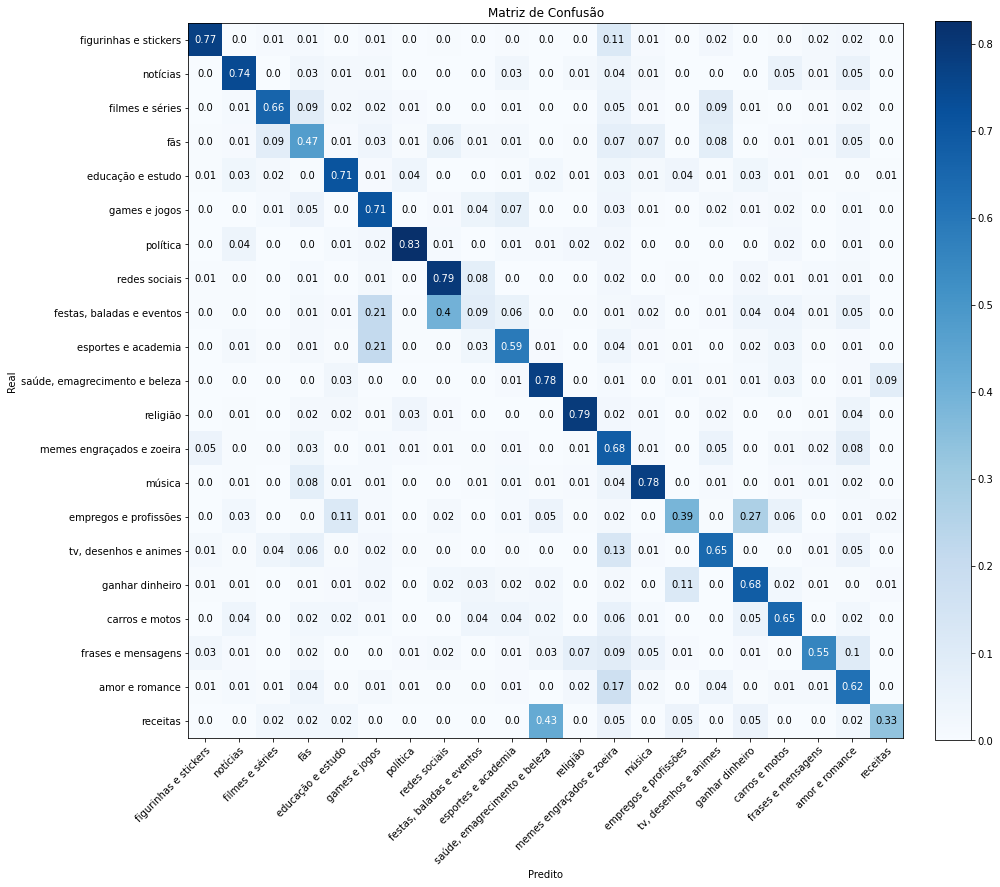

In [115]:
plot_confusion_matrix(cnn_model_db2, results, CATEGORY_BASE2[test_index])

## Dataset 2: Precisão das Classes

In [102]:
y_true = np.argmax(CATEGORY_BASE2[test_index], axis=1)
y_pred = np.argmax(results, axis=1)
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.43      0.28       195
           1       0.33      0.33      0.33        39
           2       0.62      0.40      0.48       258
           3       0.12      0.64      0.21        50
           4       0.58      0.62      0.60        29
           5       0.06      0.21      0.10        66
           6       0.69      0.47      0.55       103
           7       0.55      0.65      0.60       110
           8       0.17      0.67      0.27        30
           9       0.81      0.57      0.67       327
          10       0.57      0.68      0.62       145
          11       0.50      0.44      0.47       164
          12       0.25      0.37      0.30        78
          13       0.80      0.49      0.61       820
          14       0.53      0.48      0.51        87
          15       0.05      0.10      0.06        10
          16       0.77      0.58      0.66       368
          17       0.54    

## Dataset 2: Principais Pontos

# AVALIANDO OS MODELOS EM BASES DIFERENTES

## Avaliando: Dataset 1 - Testando no Dataset 2

In [111]:
results = cnn_model_db1.predict(SENTENCES_BASE2)
y_true = np.argmax(CATEGORY_BASE2, axis=1)
y_pred = np.argmax(results, axis=1)

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.19      0.20      8942
           1       0.02      0.66      0.03       451
           2       0.12      0.18      0.14      3727
           3       0.07      0.38      0.12      1745
           4       0.11      0.23      0.15       412
           5       0.03      0.25      0.06      1923
           6       0.56      0.22      0.32      2882
           7       0.51      0.19      0.28      2078
           8       0.01      0.01      0.01       283
           9       0.80      0.44      0.57     12513
          10       0.52      0.10      0.16      5071
          11       0.39      0.21      0.28      3552
          12       0.08      0.16      0.11       899
          13       0.77      0.03      0.05     26958
          14       0.20      0.35      0.25      1716
          15       0.07      0.14      0.09       175
          16       0.74      0.26      0.39      6783
          17       0.27    

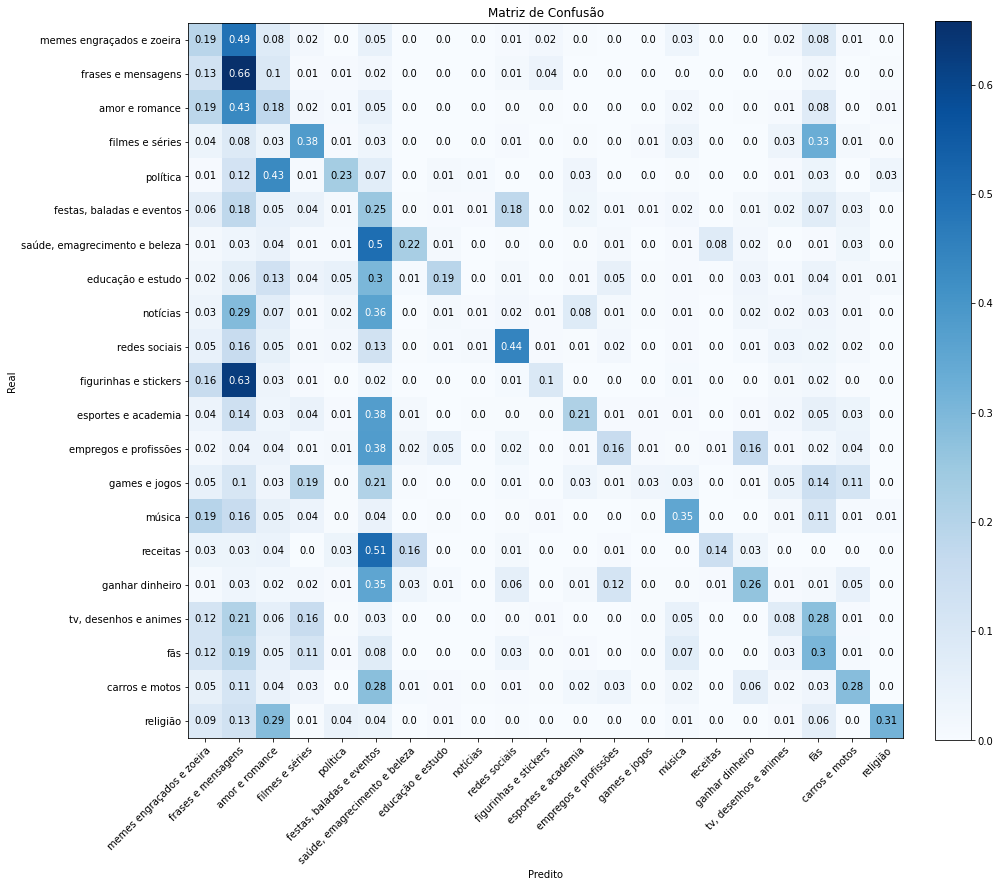

In [112]:
plot_confusion_matrix(cnn_model_db1, results, CATEGORY_BASE2)

## Avaliando: Dataset 2 - Testando no Dataset 1

In [122]:
results = cnn_model_db2.predict(SENTENCES_BASE1)
y_true = np.argmax(CATEGORY_BASE1, axis=1)
y_pred = np.argmax(results, axis=1)
    
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.21      0.16      0.18      1053
           1       0.33      0.13      0.19       371
           2       0.41      0.06      0.10       727
           3       0.16      0.62      0.26       929
           4       0.18      0.55      0.27        83
           5       0.03      0.04      0.03       159
           6       0.50      0.59      0.54       907
           7       0.52      0.47      0.50       830
           8       0.23      0.29      0.26       174
           9       0.57      0.48      0.52       969
          10       0.53      0.54      0.53       536
          11       0.75      0.44      0.55      1060
          12       0.15      0.05      0.07       568
          13       0.64      0.49      0.55      2394
          14       0.28      0.41      0.34       953
          15       0.08      0.19      0.11       124
          16       0.59      0.79      0.68      2171
          17       0.33    

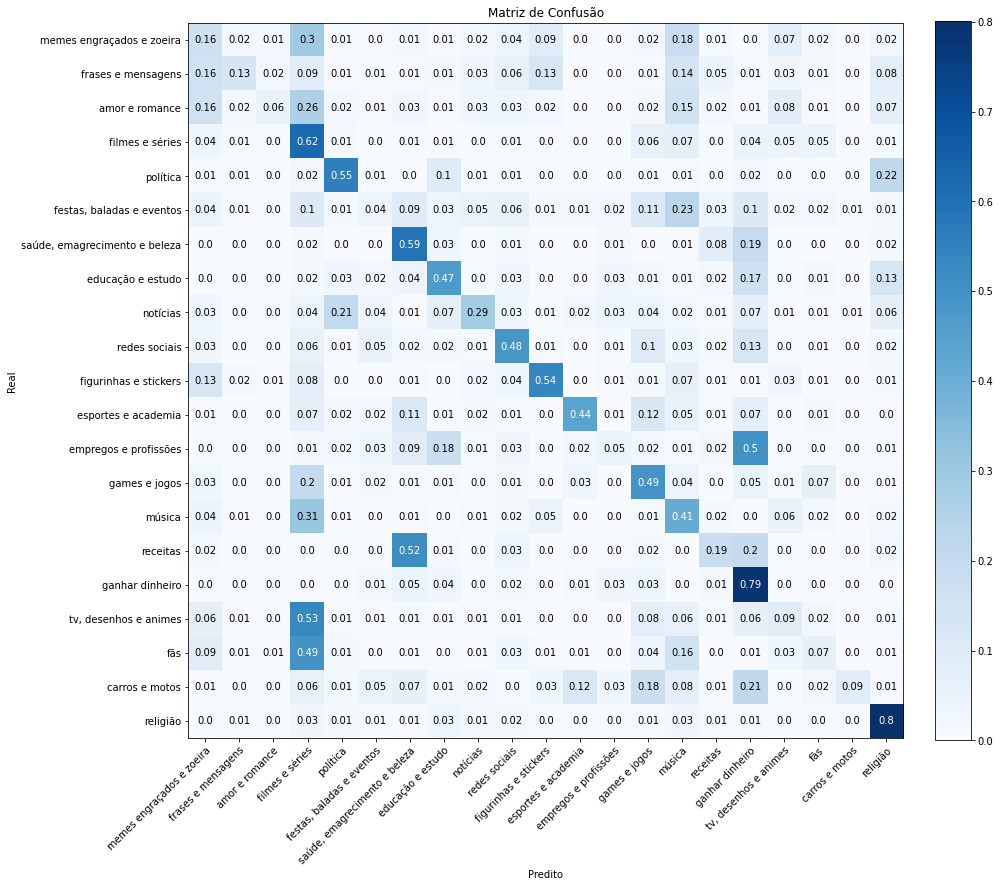

In [123]:
plot_confusion_matrix(lstm_model_db2, results, CATEGORY_BASE1)

## Principais Pontos

# CONCLUSÃO